=== STARTING ANALYSIS ===

--- Parsing Stimulus File ---
Area 8: 2820 neurons
Area 30: 1810 neurons
Area 34: 1910 neurons

=== CO-STIMULATION ANALYSIS ===

Solo stimulation during steps 150000-152000:
  - 8 (2820 neurons)

Solo stimulation during steps 200000-202000:
  - 30 (1810 neurons)

Solo stimulation during steps 250000-252000:
  - 34 (1910 neurons)

Solo stimulation during steps 300000-302000:
  - 8 (2820 neurons), 30 (1810 neurons)

Solo stimulation during steps 350000-352000:
  - 34 (1910 neurons)

Solo stimulation during steps 400000-402000:
  - 8 (2820 neurons), 30 (1810 neurons)

Solo stimulation during steps 450000-452000:
  - 34 (1910 neurons)

Solo stimulation during steps 500000-502000:
  - 8 (2820 neurons), 30 (1810 neurons)

Solo stimulation during steps 550000-552000:
  - 34 (1910 neurons)

Solo stimulation during steps 652000-654000:
  - 30 (1810 neurons)

Solo stimulation during steps 702000-704000:
  - 34 (1910 neurons)

✓ Saved: C:\Users\A\Desktop\MSc CLS\SVVR\pr

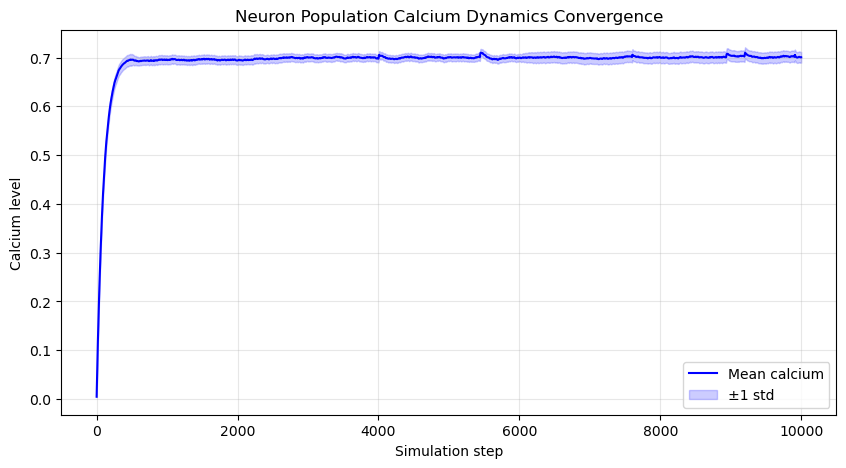


--- Calculating Convergence Times ---
✓ Saved: C:\Users\A\Desktop\MSc CLS\SVVR\project\analysis_results/calcium_convergence_hist.png


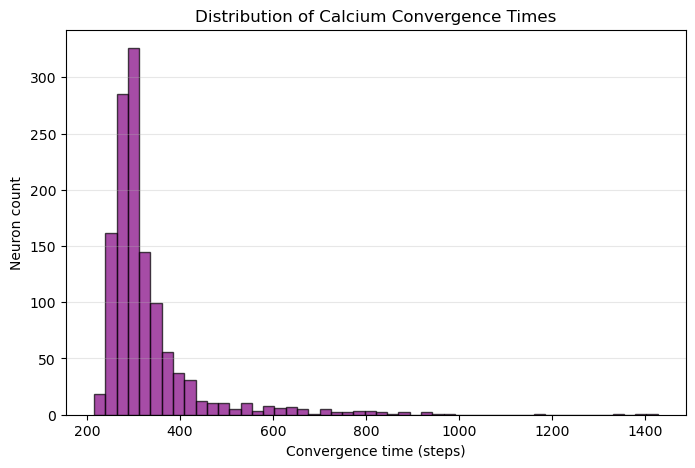


=== CONVERGENCE STATISTICS ===
Median convergence time: 298.50 steps
90th percentile: 414.00 steps
Non-converged neurons: 0 / 1264


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, Dict, List, Tuple

# ==========================================
# 1. CONFIGURATION
# ==========================================

# Paths (Using the exact paths you provided)
PROJECT_ROOT = Path(r"C:/Users/A/Desktop/MSc CLS/SVVR/project")
VIZ_CALCIUM_DIR = PROJECT_ROOT / "viz-calcium"
VIZ_STIMULUS_DIR = PROJECT_ROOT / "viz-stimulus"
STIMULUS_FILE = VIZ_STIMULUS_DIR / "stimulus.txt"  
POS_FILE = VIZ_CALCIUM_DIR / "positions" / "rank_0_positions.txt"
MONITOR_DIR = VIZ_STIMULUS_DIR / "monitors"
OUTPUT_DIR = PROJECT_ROOT / "analysis_results"

# Analysis Parameters
MAX_NEURONS = 2000      # smaller for temporal analysis
MAX_STEPS = 200000      # enough to observe convergence

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(VIZ_STIMULUS_DIR, exist_ok=True)


# ==========================================
# 2. STIMULUS PARSING FUNCTIONS
# ==========================================

def parse_stimulus_line(line, areas_dict):
    """
    Parse a stimulus line:
    Format: <start>-<end>:<frequency> <intensity> <neuron_ids>
    """
    # Split by whitespace
    parts = line.split()
    
    # Parse time range and frequency
    time_freq = parts[0]
    time_range, frequency = time_freq.split(':')
    start, end = map(int, time_range.split('-'))
    frequency = int(frequency)
    
    # Parse intensity
    intensity = float(parts[1])
    
    # Parse neuron IDs
    neuron_ids_str = ' '.join(parts[2:])
    neurons = [int(x) - 1 for x in neuron_ids_str.split() if x.isdigit()]  # 0-indexed
    
    # Determine which areas these neurons belong to
    area_names = []
    for area_name, area_neurons in areas_dict.items():
        overlap = len(set(neurons) & set(area_neurons))
        if overlap > 0:
            area_names.append(f"{area_name} ({overlap} neurons)")
    
    return {
        'start': start,
        'end': end,
        'frequency': frequency,
        'intensity': intensity,
        'neurons': neurons,
        'area_names': ', '.join(area_names) if area_names else 'unknown'
    }

def parse_stimulus_file(stimulus_file_path):
    """
    Parse the stimulus.txt file to extract:
    1. Area definitions (which neurons belong to which area)
    2. Stimulation protocol (when/how areas are stimulated)
    """
    areas_dict = {}
    stimuli = []
    
    if not os.path.exists(stimulus_file_path):
        print(f"Warning: Stimulus file not found at {stimulus_file_path}")
        return areas_dict, stimuli

    with open(stimulus_file_path, 'r') as f:
        lines = f.readlines()
    
    current_area = None
    
    for line in lines:
        line = line.strip()
        
        # Skip empty lines
        if not line:
            continue
        
        # Check if this is an area definition line
        if line.startswith('#') and 'area_' in line.lower():
            parts = line.split(':')
            if len(parts) >= 2:
                area_part = parts[0].replace('#', '').strip()
                area_name = area_part.split('_')[-1]
                
                neuron_str = parts[1].strip()
                if neuron_str.startswith('us'):
                    neuron_str = neuron_str[2:].strip()
                
                neuron_ids = [int(x) - 1 for x in neuron_str.split() if x.isdigit()]
                
                areas_dict[area_name] = neuron_ids
                current_area = area_name
                print(f"Area {area_name}: {len(neuron_ids)} neurons")
        
        # Check if this is a stimulus definition line
        elif '-' in line and ':' in line and not line.startswith('#'):
            try:
                stimulus_info = parse_stimulus_line(line, areas_dict)
                stimuli.append(stimulus_info)
            except Exception as e:
                print(f"Could not parse stimulus line: {line}")
                print(f"Error: {e}")
    
    return areas_dict, stimuli

def analyze_co_stimulation(stimuli):
    """
    Analyze which areas are co-stimulated (key for understanding learning)
    """
    print("\n=== CO-STIMULATION ANALYSIS ===")
    
    # Group stimuli by time window
    time_windows = {}
    for stim in stimuli:
        key = (stim['start'], stim['end'])
        if key not in time_windows:
            time_windows[key] = []
        time_windows[key].append(stim)
    
    for time_key, stims in time_windows.items():
        if len(stims) > 1:
            print(f"\nCo-stimulation during steps {time_key[0]}-{time_key[1]}:")
            for stim in stims:
                print(f"  - {stim['area_names']}")
            print("  -> These areas should form connections (Hebbian learning)!")
        else:
            print(f"\nSolo stimulation during steps {time_key[0]}-{time_key[1]}:")
            print(f"  - {stims[0]['area_names']}")

def visualize_stimulus_protocol(areas_dict, stimuli, output_dir):
    """
    Create visualizations showing timeline and areas
    """
    if not stimuli or not areas_dict:
        print("No stimulus data to visualize.")
        return

    os.makedirs(output_dir, exist_ok=True)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
    
    # Plot 1: Stimulus timeline
    area_colors = {'8': '#FF6B6B', '30': '#4ECDC4', '34': '#FFD93D'}
    y_position = 0
    
    for stim in stimuli:
        start = stim['start']
        end = stim['end']
        area_names = stim.get('area_names', '')
        
        color = 'gray'
        for area in area_colors.keys():
            if f"area {area}" in area_names.lower() or f"Area {area}" in area_names:
                color = area_colors[area]
                break
        
        ax1.barh(y_position, end - start, left=start, height=0.6, 
                 color=color, alpha=0.7, edgecolor='black', linewidth=1)
        
        label = area_names.split('(')[0].strip()
        ax1.text(start + (end-start)/2, y_position, label, 
                 ha='center', va='center', fontsize=9, fontweight='bold')
        y_position += 1
    
    ax1.set_xlabel('Simulation Step', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Stimulus Event', fontsize=13, fontweight='bold')
    ax1.set_title('Stimulation Timeline', fontsize=15, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Plot 2: Neuron count per area
    area_names_sorted = sorted(areas_dict.keys(), key=lambda x: int(x) if x.isdigit() else 0)
    neuron_counts = [len(areas_dict[a]) for a in area_names_sorted]
    colors_bar = [area_colors.get(a, 'gray') for a in area_names_sorted]
    
    bars = ax2.bar(area_names_sorted, neuron_counts, color=colors_bar, 
                   alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax2.set_ylabel('Number of Neurons')
    ax2.set_title('Neuron Distribution by Area')
    
    # Add counts
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    save_path = os.path.join(output_dir, 'stimulus_protocol.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved: {save_path}")
    plt.close()


# ==========================================
# 3. CALCIUM & POSITION LOADING FUNCTIONS
# ==========================================

def load_positions(positions_file: str, max_neurons: Optional[int] = None):
    """
    Load neuron positions from file.
    Format: <nid+1> <x> <y> <z> <area> "ex"
    """
    positions = {}
    areas = {}
    
    if not os.path.exists(positions_file):
        print(f"Error: Position file not found at {positions_file}")
        return {}, {}, []

    with open(positions_file) as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split()
            
            if len(parts) < 5:
                continue
            
            try:
                nid = int(parts[0]) - 1  # Convert to zero-based
                x, y, z = map(float, parts[1:4])
                area = parts[4]
                
                positions[nid] = (x, y, z)
                areas[nid] = area
            except (ValueError, IndexError):
                continue
    
    all_ids_sorted = sorted(positions.keys())
    subset_ids = all_ids_sorted[:max_neurons] if max_neurons else all_ids_sorted
    
    return positions, areas, subset_ids

def load_calcium_series(monitor_dir: str, subset_ids, max_steps=None):
    calcium_data = {}
    
    if not os.path.exists(monitor_dir):
        print(f"Error: Monitor dir not found at {monitor_dir}")
        return {}

    count = 0
    total = len(subset_ids)
    print(f"Loading calcium traces for {total} neurons...")

    for nid in subset_ids:
        path = Path(monitor_dir) / f"0_{nid}.csv"
        if not path.exists():
            continue

        try:
            # Assuming format: step;...;...;...;...;calcium
            df = pd.read_csv(path, sep=";", header=None, nrows=max_steps)
            calcium_data[nid] = df.iloc[:, 5].astype(float).to_numpy()
            count += 1
            if count % 100 == 0:
                print(f"  Loaded {count}/{total}...")
        except Exception:
            continue

    return calcium_data

def estimate_convergence_time(trace, plateau, eps_frac=0.05, min_duration=200):
    """
    Finds the first time step where the trace stays within 
    eps_frac of the plateau value for at least min_duration steps.
    """
    eps = eps_frac * plateau
    # Optimization: iterate backwards or use numpy for speed
    # Simple forward implementation:
    is_converged = np.abs(trace - plateau) <= eps
    
    # Convolve with a kernel of ones to find continuous regions
    kernel = np.ones(min_duration)
    convolved = np.convolve(is_converged.astype(int), kernel, mode='valid')
    
    # Find first index where convolution equals min_duration
    indices = np.where(convolved == min_duration)[0]
    
    if len(indices) > 0:
        return indices[0]
    return np.nan


# ==========================================
# 4. MAIN EXECUTION LOGIC
# ==========================================

def main():
    print("=== STARTING ANALYSIS ===")

    # --- STEP 1: Stimulus Analysis ---
    print("\n--- Parsing Stimulus File ---")
    stim_areas, stimuli = parse_stimulus_file(str(STIMULUS_FILE))
    
    analyze_co_stimulation(stimuli)
    visualize_stimulus_protocol(stim_areas, stimuli, output_dir=str(OUTPUT_DIR))


    # --- STEP 2: Load Neuron Positions ---
    print("\n--- Loading Positions ---")
    positions, pos_areas, subset_ids = load_positions(str(POS_FILE), MAX_NEURONS)
    print(f"Loaded {len(subset_ids)} neurons for calcium analysis.")


    # --- STEP 3: Load Calcium Data ---
    print("\n--- Loading Calcium Traces ---")
    calcium_data = load_calcium_series(
        monitor_dir=str(MONITOR_DIR),
        subset_ids=subset_ids,
        max_steps=MAX_STEPS,
    )
    
    if not calcium_data:
        print("No calcium data found. Exiting.")
        return

    # Create Matrix for visualization
    min_len = min(len(v) for v in calcium_data.values())
    calcium_matrix = np.vstack([v[:min_len] for v in calcium_data.values()])
    
    mean_over_time = calcium_matrix.mean(axis=0)
    std_over_time = calcium_matrix.std(axis=0)


    # --- STEP 4: Calcium Visualization (Population Dynamics) ---
    plt.figure(figsize=(10, 5))
    plt.plot(mean_over_time, label="Mean calcium", color='blue')
    plt.fill_between(
        np.arange(min_len),
        mean_over_time - std_over_time,
        mean_over_time + std_over_time,
        color='blue', alpha=0.2,
        label="±1 std"
    )
    plt.xlabel("Simulation step")
    plt.ylabel("Calcium level")
    plt.title("Neuron Population Calcium Dynamics Convergence")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(OUTPUT_DIR / "calcium_population_dynamics.png")
    print(f"✓ Saved: {OUTPUT_DIR}/calcium_population_dynamics.png")
    plt.show()


    # --- STEP 5: Convergence Analysis ---
    print("\n--- Calculating Convergence Times ---")
    
    # FIX: We must define the plateau target for every neuron.
    # We assume the plateau is the average of the last 1000 steps of the trace.
    plateau_calcium = {nid: np.mean(trace[-1000:]) for nid, trace in calcium_data.items()}
    
    convergence_times = {}
    for nid, trace in calcium_data.items():
        plateau = plateau_calcium[nid]
        convergence_times[nid] = estimate_convergence_time(trace, plateau)

    conv_vals = np.array([v for v in convergence_times.values() if not np.isnan(v)])

    # Histogram of Convergence
    plt.figure(figsize=(8, 5))
    plt.hist(conv_vals, bins=50, color='purple', alpha=0.7, edgecolor='black')
    plt.xlabel("Convergence time (steps)")
    plt.ylabel("Neuron count")
    plt.title("Distribution of Calcium Convergence Times")
    plt.grid(axis='y', alpha=0.3)
    plt.savefig(OUTPUT_DIR / "calcium_convergence_hist.png")
    print(f"✓ Saved: {OUTPUT_DIR}/calcium_convergence_hist.png")
    plt.show()

    # Statistics
    print("\n=== CONVERGENCE STATISTICS ===")
    if len(conv_vals) > 0:
        print(f"Median convergence time: {np.nanmedian(conv_vals):.2f} steps")
        print(f"90th percentile: {np.nanpercentile(conv_vals, 90):.2f} steps")
    
    non_converged_count = np.isnan(list(convergence_times.values())).sum()
    print(f"Non-converged neurons: {non_converged_count} / {len(calcium_data)}")

if __name__ == "__main__":
    main()